# Record Sound

In [1]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters for recording
CHUNK = 1024            # Number of audio samples per buffer
FORMAT = pyaudio.paInt16  # 16-bit resolution
CHANNELS = 1            # Mono audio
RATE = 44100            # Sampling rate in Hz
RECORD_SECONDS = 5      # Duration of recording in seconds

In [4]:
def record_audio():
    # Initialize the audio stream
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("Recording...")
    frames = []

    # Record audio in chunks and append to frames
    for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("Finished recording.")
    stream.stop_stream()
    stream.close()
    p.terminate()

    return frames




In [5]:
from pydub import AudioSegment

def from_mp3(file_path):

    audio_file_path = file_path  # Replace with your MP3 file path
    audio = AudioSegment.from_mp3(audio_file_path)
    
    # Convert the audio to raw PCM data (in this case, 16-bit mono)
    audio = audio.set_channels(1)  # Ensure mono
    audio = audio.set_frame_rate(RATE)  # Match the desired sample rate
    
    # Convert audio to raw bytes
    raw_audio_data = audio.raw_data
    
    # Process the audio data in chunks as you would with live input
    frames = [raw_audio_data[i:i + CHUNK] for i in range(0, len(raw_audio_data), CHUNK)]
    return frames


In [6]:
#frames = from_mp3('/Users/francescobassignana/Downloads/VoglioTrapAnarty.mp3')
frames = record_audio()

Recording...
Finished recording.


In [10]:
# Convert the byte data to numpy array
#print(np.frombuffer(frames[0], dtype=np.int16))
audio_data = b''.join(frames)
audio_array = np.frombuffer(audio_data, dtype=np.int16)
audio_array

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

array([   0,    0,    0, ..., 1261, 1329, 1369], dtype=int16)

Text(0, 0.5, 'Amplitude')

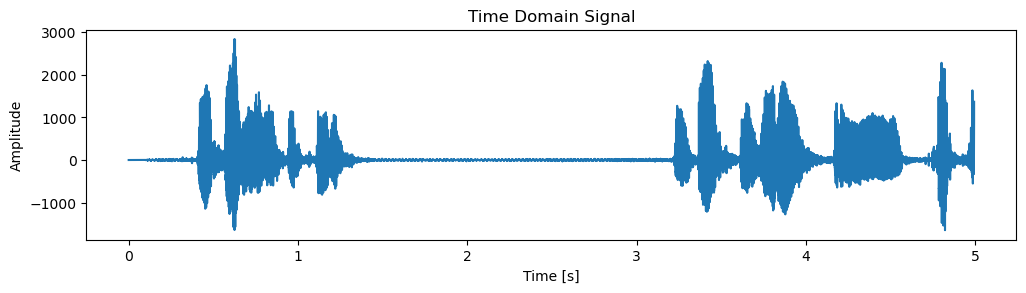

In [11]:
# Create a time axis for the time-domain plot
time_axis = np.linspace(0, len(audio_array) / RATE, num=len(audio_array))

# Plot the time-domain signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_axis, audio_array)
plt.title('Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

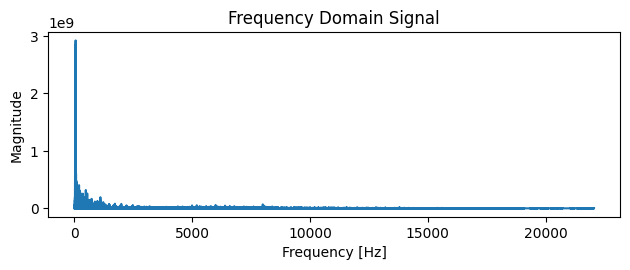

In [10]:
# Compute the Fourier Transform for the frequency-domain plot
fft_data = np.fft.fft(audio_array)
fft_freq = np.fft.fftfreq(len(audio_array), d=1/RATE)

# Use only the positive half of the spectrum
positive_freqs = fft_freq[:len(fft_freq)//2]
fft_magnitude = np.abs(fft_data[:len(fft_data)//2])

# Plot the frequency-domain signal
plt.subplot(2, 1, 2)
plt.plot(positive_freqs, fft_magnitude)
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [11]:
gaussian_kernel = [0.00766381, 0.01189906, 0.0176778, 0.02512993, 0.03418235,
 0.04448978, 0.0554072, 0.06602672, 0.07528715, 0.08214282,
 0.08575629, 0.0856663, 0.08188448, 0.07489293, 0.0655432,
 0.05488606, 0.04397888, 0.03371893, 0.02473723, 0.01736505,
 0.01166403]

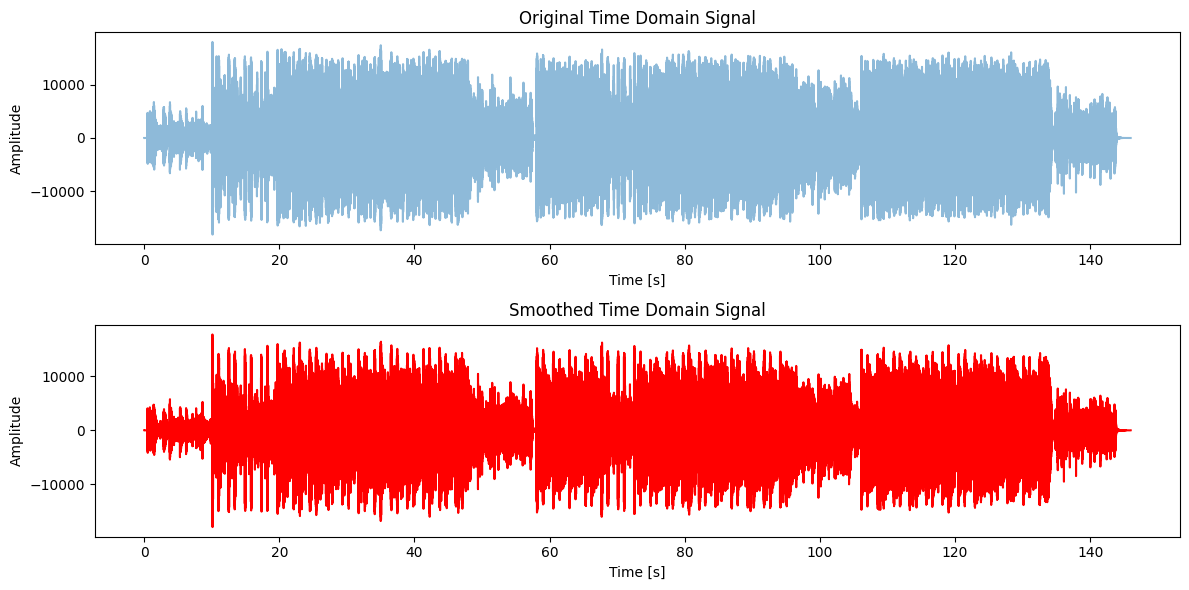

In [12]:
def gaussian_kernel(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

# Generate a Gaussian kernel with a specified size and sigma for smoothing
kernel = gaussian_kernel(size=21, sigma=5)

# Apply the Gaussian kernel to smooth the audio signal using numpy's convolution
smoothed_audio = np.convolve(audio_array, kernel, mode='same')

# Plot the original and smoothed signals
plt.figure(figsize=(12, 6))

# Plot original time-domain signal
plt.subplot(2, 1, 1)
plt.plot(time_axis, audio_array, label='Original Signal', alpha=0.5)
plt.title('Original Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot smoothed time-domain signal
plt.subplot(2, 1, 2)
plt.plot(time_axis, smoothed_audio, label='Smoothed Signal', color='red')
plt.title('Smoothed Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Using Hanning Window

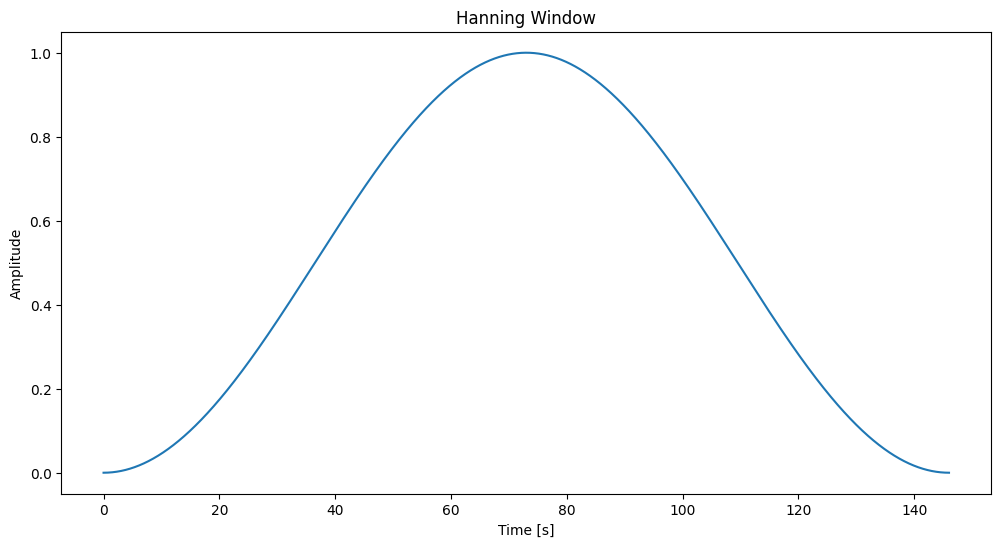

In [13]:
hanning_window = np.hanning(len(audio_array))
time_axis = np.linspace(0, len(audio_array) / RATE, num=len(audio_array))

#plot the hanning window
plt.figure(figsize=(12, 6))
plt.plot(time_axis, hanning_window)
plt.title('Hanning Window')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

#fft on hann window




In [14]:
"""def gaussian_kernel(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

# Generate a Gaussian kernel with a specified size and sigma for smoothing
kernel = gaussian_kernel(size=21, sigma=5)

# Apply the Gaussian kernel to smooth the audio signal using numpy's convolution
smoothed_audio = np.convolve(audio_array, kernel, mode='same') * np.hanning(len(audio_array))
new_audio_array = audio_array * np.hanning(len(audio_array))
# Plot the original and smoothed signals
plt.figure(figsize=(12, 6))

# Plot original time-domain signal
plt.subplot(2, 1, 1)
plt.plot(time_axis, new_audio_array, label='Original Signal with Hanning window', alpha=0.5)
plt.title('Original Signal with Hanning window')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot smoothed time-domain signal
plt.subplot(2, 1, 2)
plt.plot(time_axis, smoothed_audio, label='Smoothed Signal with Hanning Window', color='red')
plt.title('Smoothed Signal with Hanning Window')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()"""
def gaussian_kernel(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

# Generate a Gaussian kernel with a specified size and sigma for smoothing
kernel = gaussian_kernel(size=21, sigma=5)
smoothed_audio = np.convolve(audio_array, kernel, mode='same') 

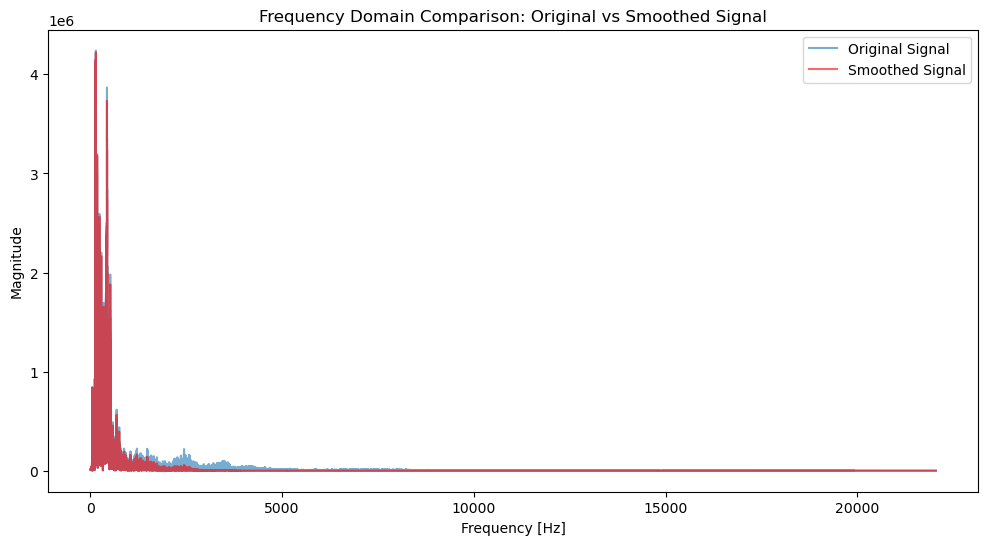

In [15]:
# Assuming audio_array, RATE, and smoothed_audio are already defined

# Perform Fourier Transform on the original audio signal
fft_original = np.fft.fft(audio_array)
fft_magnitude_original = np.abs(fft_original)  # Magnitude of original FFT
fft_frequency = np.fft.fftfreq(len(audio_array), 1 / RATE)  # Frequency axis

# Perform Fourier Transform on the smoothed audio signal
fft_smoothed = np.fft.fft(smoothed_audio)
fft_magnitude_smoothed = np.abs(fft_smoothed)  # Magnitude of smoothed FFT

# Only keep the positive frequencies for both signals
positive_freq_indices = np.where(fft_frequency >= 0)
fft_frequency = fft_frequency[positive_freq_indices]
fft_magnitude_original = fft_magnitude_original[positive_freq_indices]
fft_magnitude_smoothed = fft_magnitude_smoothed[positive_freq_indices]

# Plot the Fourier Transform of both signals
plt.figure(figsize=(12, 6))
plt.plot(fft_frequency, fft_magnitude_original, label="Original Signal", alpha=0.6)
plt.plot(fft_frequency, fft_magnitude_smoothed, label="Smoothed Signal", color="red", alpha=0.6)
plt.title("Frequency Domain Comparison: Original vs Smoothed Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Musical Notes Analysis

In [18]:
def get_dominant_freq(data, fs):

    window = np.hanning(len(data))
    data = data * window

    # Compute FFT
    fft_spectrum = np.fft.rfft(data)
    fft_magnitude = np.abs(fft_spectrum)
    freqs = np.fft.rfftfreq(len(data), d=1/fs)

    # Ignore frequencies below 50 Hz
    idx = np.where(freqs > 50)
    freqs = freqs[idx]
    fft_magnitude = fft_magnitude[idx]

    # Find the peak frequency
    peak_idx = np.argmax(fft_magnitude)
    peak_freq = freqs[peak_idx]
    return peak_freq

In [19]:
def freq_to_note_name(frequency):
    A4 = 440.0
    C0 = A4 * pow(2, -4.75)  # Frequency of C0

    if frequency == 0:
        return None

    # Calculate the number of semitones from C0
    h = round(12 * np.log2(frequency / C0))
    octave = h // 12
    n = h % 12
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    note_name = note_names[n] + str(octave)
    return note_name

In [20]:

def get_notes():

    notes = [freq_to_note_name(get_dominant_freq(np.frombuffer(data, dtype=np.int16), RATE)) for data in frames]
    print(len(notes))
    # function that transform this ['F2', 'F2', 'F4', 'C3', 'C3', 'C3', 'C3', 'G4', 'F4', 'F4', 'F4'] into this [('F2',2), ('F4',1),('C3',4),...]
    result= []
    idx= 0
    
    while idx<len(notes):
        n = notes[idx]
        counter = 0
        # Count consecutive occurrences of the note
        while idx < len(notes) and notes[idx] == n:
            counter += 1
            idx += 1
        result.append((n,counter))
    return result
result = get_notes()


215


In [21]:
"""

times = []  # to store the time for each note change
note_changes = []  # to store the note at each change
current_time = 0  # starting time

for note, count in result:
    times.append(current_time)
    note_changes.append(note)
    current_time += count * (CHUNK / RATE)  # each chunk corresponds to CHUNK/RATE seconds

# Plotting the time-domain signal with notes overlayed
plt.figure(figsize=(12, 6))

# Plot original time-domain signal
plt.subplot(2, 1, 1)
plt.plot(time_axis, new_audio_array, label='Original Signal with Hanning window', alpha=0.5)
plt.title('Original Signal with Hanning window')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Overlay vertical lines for the note changes
for t in times:
    plt.axvline(x=t, color='r', linestyle='--', alpha=0.5)

# Plot smoothed time-domain signal
plt.subplot(2, 1, 2)
plt.plot(time_axis, smoothed_audio, label='Smoothed Signal with Hanning Window', color='red')
plt.title('Smoothed Signal with Hanning Window')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Overlay vertical lines for the note changes
for t in times:
    plt.axvline(x=t, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
"""
# Now we create the time chart with vertical lines for each note change


"\n\ntimes = []  # to store the time for each note change\nnote_changes = []  # to store the note at each change\ncurrent_time = 0  # starting time\n\nfor note, count in result:\n    times.append(current_time)\n    note_changes.append(note)\n    current_time += count * (CHUNK / RATE)  # each chunk corresponds to CHUNK/RATE seconds\n\n# Plotting the time-domain signal with notes overlayed\nplt.figure(figsize=(12, 6))\n\n# Plot original time-domain signal\nplt.subplot(2, 1, 1)\nplt.plot(time_axis, new_audio_array, label='Original Signal with Hanning window', alpha=0.5)\nplt.title('Original Signal with Hanning window')\nplt.xlabel('Time [s]')\nplt.ylabel('Amplitude')\n\n# Overlay vertical lines for the note changes\nfor t in times:\n    plt.axvline(x=t, color='r', linestyle='--', alpha=0.5)\n\n# Plot smoothed time-domain signal\nplt.subplot(2, 1, 2)\nplt.plot(time_axis, smoothed_audio, label='Smoothed Signal with Hanning Window', color='red')\nplt.title('Smoothed Signal with Hanning Windo

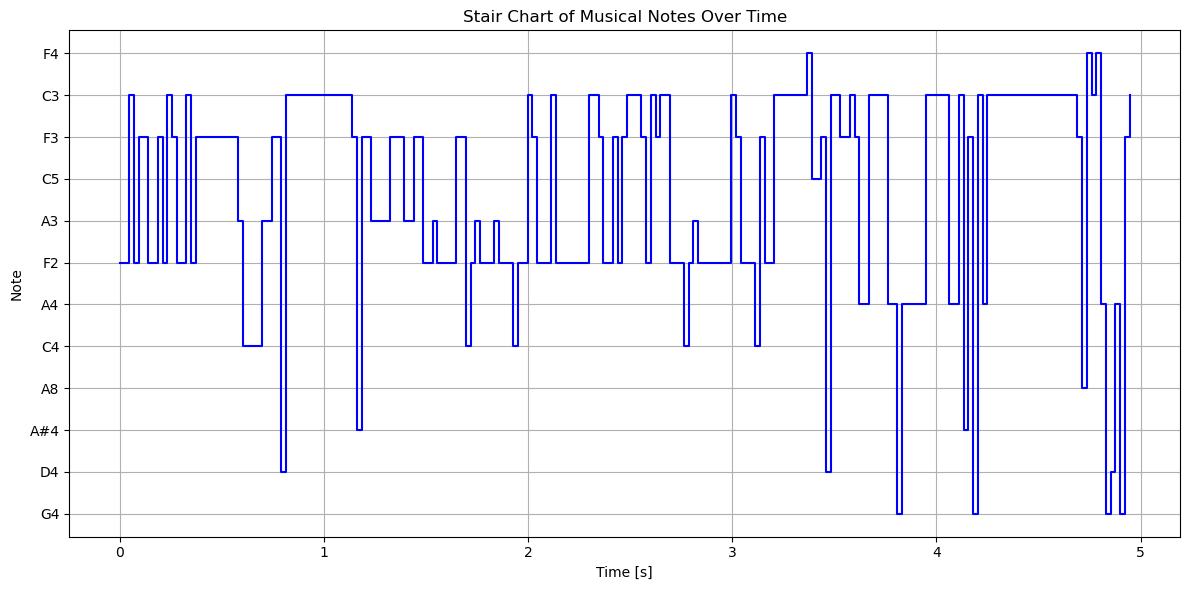

In [22]:

# Now we create the time chart with vertical lines for each note change
times = []  # to store the time for each note change
note_changes = []  # to store the note at each change
current_time = 0  # starting time

for note, count in result:
    times.append(current_time)
    note_changes.append(note)
    current_time += count * (CHUNK / RATE)  # each chunk corresponds to CHUNK/RATE seconds

# Convert the note changes into numeric values for plotting
note_to_num = {note: i for i, note in enumerate(set(note_changes))}
numeric_notes = [note_to_num[n] for n in note_changes]

# Plotting the "stair" chart
plt.figure(figsize=(12, 6))
plt.step(times, numeric_notes, where='post', color='blue', label='Musical Notes')

# Label the y-axis with note names
plt.yticks(list(note_to_num.values()), list(note_to_num.keys()))

plt.title('Stair Chart of Musical Notes Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Note')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:

def plot_note_window(start_time, end_time):
    # Filter the times and note_changes to include only data within the specified time window
    filtered_times = []
    filtered_notes = []

    for time, note in zip(times, note_changes):
        if start_time <= time <= end_time:
            filtered_times.append(time)
            filtered_notes.append(note)

    # Convert the filtered notes into numeric values for plotting
    filtered_numeric_notes = [note_to_num[n] for n in filtered_notes]

    # Plotting the "stair" chart for the specific time window
    plt.figure(figsize=(12, 6))
    plt.step(filtered_times, filtered_numeric_notes, where='post', color='blue', label='Musical Notes')

    # Label the y-axis with note names
    plt.yticks(list(note_to_num.values()), list(note_to_num.keys()))

    # Set titles and labels
    plt.title(f'Stair Chart of Musical Notes Over Time (Window: {start_time}s to {end_time}s)')
    plt.xlabel('Time [s]')
    plt.ylabel('Note')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

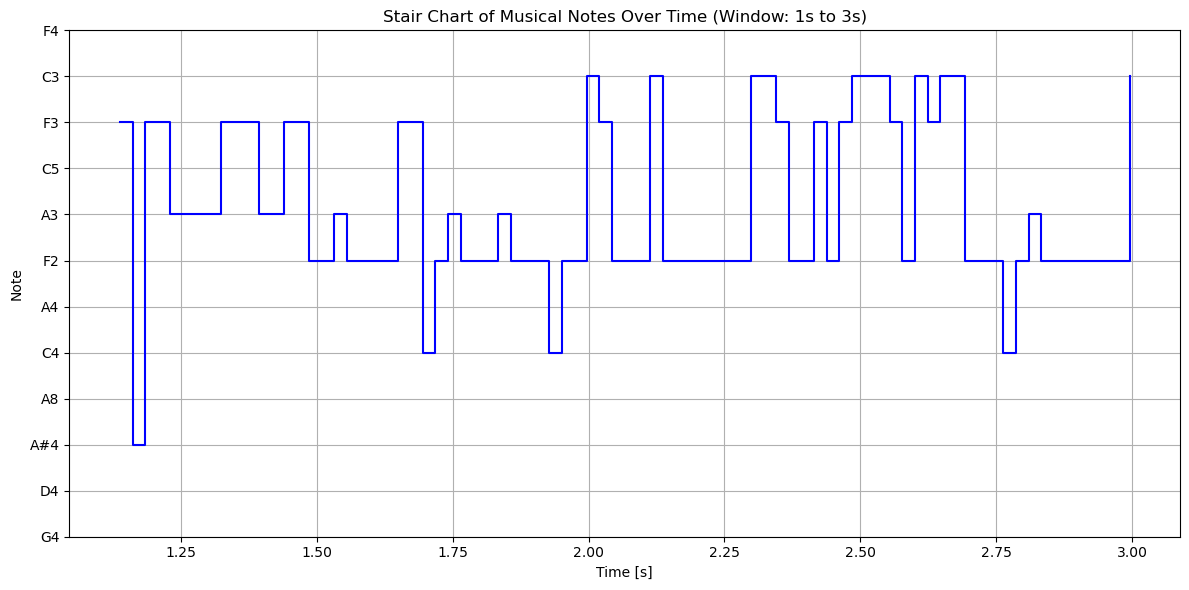

In [25]:
plot_note_window(1,3)

In [28]:
import numpy as np
import librosa

def calculate_bpm(frames, rate=RATE):
    """
    Calculate the BPM of audio data from raw PCM frames.
    
    :param frames: List of raw audio data chunks.
    :param rate: Sampling rate of the audio.
    :return: Estimated BPM.
    """
    # Concatenate all the frames into a single audio signal
    raw_audio_data = b"".join(frames)
    
    # Convert raw audio bytes to numpy array
    audio_samples = np.frombuffer(raw_audio_data, dtype=np.int16)  # Assuming 16-bit audio
    
    # Normalize the audio to float values between -1 and 1
    audio_samples = librosa.util.buf_to_float(audio_samples, n_bytes=2)
    
    # Use librosa to calculate the tempo (BPM)
    tempo, beats = librosa.beat.beat_track(y=audio_samples, sr=rate)
    
    return tempo, beats

In [29]:
tempo, beats = calculate_bpm(frames)
tempo


array([112.34714674])

In [30]:
beats

array([ 38,  84, 133, 182, 231, 280, 326, 379, 430])

In [31]:
def beats_per_chunk(bpm, rate=RATE):
    
    period = 1/rate
    seconds_per_beat = 60/bpm
    beats_per_sample = seconds_per_beat/period
    return beats_per_sample * CHUNK

In [32]:
BEATS_PER_CHUNK = beats_per_chunk(tempo)[0]
BEATS_PER_CHUNK

24117247.999999996

In [33]:
new_notes_array = []
for note in result:
    new_notes_array.append((note[0] , note[1]*BEATS_PER_CHUNK))

new_notes_array

[('F2', 48234495.99999999),
 ('C3', 24117247.999999996),
 ('F2', 24117247.999999996),
 ('F3', 48234495.99999999),
 ('F2', 48234495.99999999),
 ('F3', 24117247.999999996),
 ('F2', 24117247.999999996),
 ('C3', 24117247.999999996),
 ('F3', 24117247.999999996),
 ('F2', 48234495.99999999),
 ('C3', 24117247.999999996),
 ('F2', 24117247.999999996),
 ('F3', 217055231.99999997),
 ('A3', 24117247.999999996),
 ('C4', 96468991.99999999),
 ('A3', 48234495.99999999),
 ('F3', 48234495.99999999),
 ('D4', 24117247.999999996),
 ('C3', 337641471.99999994),
 ('F3', 24117247.999999996),
 ('A#4', 24117247.999999996),
 ('F3', 48234495.99999999),
 ('A3', 96468991.99999999),
 ('F3', 72351743.99999999),
 ('A3', 48234495.99999999),
 ('F3', 48234495.99999999),
 ('F2', 48234495.99999999),
 ('A3', 24117247.999999996),
 ('F2', 96468991.99999999),
 ('F3', 48234495.99999999),
 ('C4', 24117247.999999996),
 ('F2', 24117247.999999996),
 ('A3', 24117247.999999996),
 ('F2', 72351743.99999999),
 ('A3', 24117247.999999996),


SyntaxError: invalid character in identifier (2990418084.py, line 1)